In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
df_2016 = pd.read_csv('ks-projects-201612.csv', encoding="ISO-8859-1")
df_2018 = pd.read_csv('ks-projects-201801.csv', encoding="ISO-8859-1")

/Users/Aleksandra/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Investigate the Differences Between Datasets
There are two datasets, but I am not sure what the difference between them is. My guess is that they contain a lot of the same data, but I want to take a look before discarding one of them.

In [3]:
df_2018.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00


In [4]:
df_2016.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN


In [5]:
df_2018.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [6]:
df_2018['deadline'] = pd.to_datetime(df_2018['deadline'])

In [7]:
df_2018['deadline'].sort_values().head()

138572   2009-05-03
213711   2009-05-16
342226   2009-05-16
28960    2009-05-20
196244   2009-05-22
Name: deadline, dtype: datetime64[ns]

In [8]:
print(df_2018.shape)
print(df_2016.shape)

(378661, 15)
(323750, 17)


In [9]:
df_2016.columns = [s.replace(' ','') for s in df_2016.columns]

In [10]:
df_2016[df_2016['deadline']!= 'USD']['deadline'].sort_values().head()

269970               Esoteric
118552    2009-05-03 08:59:59
292628    2009-05-16 01:10:00
182855    2009-05-16 11:59:00
24856     2009-05-20 21:50:00
Name: deadline, dtype: object

#### Differences:
- the 2018 file is an extension of the 2016 file
    - 2018 file has about 55,000 more entries
- 2016 file has an extra two columns, but these are mostly null values so we would drop these features anyway

Conclusion is that we should just use the 2018 dataset for the analysis of Kickstarter Projects, just because it is essentially a more substantial dataset


### Analysis of Features

There are numerous categorical variables in this dataset that must be encoded:
- category, main_categotu, currency, state, country.

However, some of these variables are also redundant. For example, we would only really need to know the realy amount of USD pledged to the project. The currency is then irrelevant, especially since we still know the relevant location. Furthermore, category and main_category are also somewhat redundant, and only one of these should be kept.

In [11]:
df = df_2018

In [12]:
print(len(df.category.unique()))
print(len(df.main_category.unique())) 
#main_category will help us keep dimensionality low after one hot encoding

159
15


In [13]:
df.shape[0]==len(df.ID.unique()) #ID column is unique, but doesnt give us much info

True

In [14]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [15]:
df.launched = pd.to_datetime(df.launched)

In [16]:
df.country.value_counts()

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

In [17]:
#assuming country N,0" is a typo. Rewriting as 'NO'

df.country = df.country.replace(to_replace='N,0"', value='NO')

In [18]:
df['cancelled'] = ((df.state == 'cancelled') | (df.state== 'suspended'))*1

In [19]:
df['success'] = (df.usd_goal_real <= df.usd_pledged_real)*1

In [20]:
df.success.describe()

count    378661.000000
mean          0.361912
std           0.480554
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: success, dtype: float64

In [21]:
df['duration'] = (df.deadline - df.launched).astype('timedelta64[h]')

In [22]:
#one hot encode categorical variables, dropping unneeded variables
df_encoded = pd.get_dummies(df.drop(labels=['name', 'launched', 'deadline', 'state','category', 'currency', 'usd pledged', 'pledged', 'ID', 'goal'], axis=1), columns=['main_category', 'country'])

In [51]:
#add a variable that shows average pledge for each project
df_encoded['average_backing'] = (df_encoded['usd_pledged_real']/(df_encoded['backers']+1))

### Data Analysis
I want to start off by understanding the data that underlies Kickstarter projects. This includes things like places of origin, predominant categories, durations, goals etc.

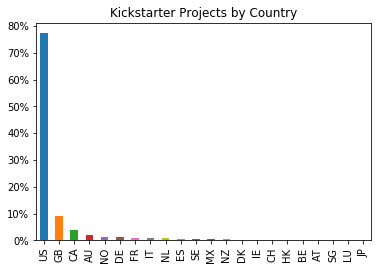

In [23]:
ax = (df.country.value_counts()/df.shape[0]*100).plot(kind='bar')
plt.title("Kickstarter Projects by Country")
ax.yaxis.set_major_formatter(PercentFormatter());

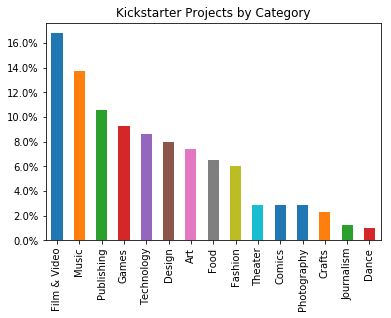

In [24]:
ax = (df.main_category.value_counts()/df.shape[0]*100).plot(kind='bar')
plt.title("Kickstarter Projects by Category")
ax.yaxis.set_major_formatter(PercentFormatter());

In [32]:
df.goal.describe()

count    3.786610e+05
mean     4.908079e+04
std      1.183391e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.200000e+03
75%      1.600000e+04
max      1.000000e+08
Name: goal, dtype: float64

The above is quite interesting as it shows us the median fundraising goal is 5,200 USD , the 75th percentile is 16,000 USD, and the 25th percentile is 2000 USD. In other words, there are plenty of kickstarter projects that do not need much to get started. Maybe this could be a key?

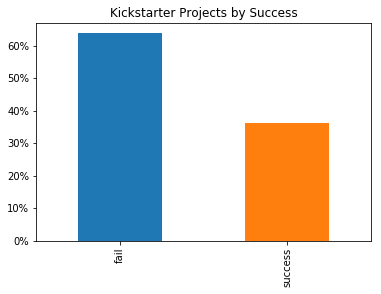

In [26]:
ax = (df_encoded.success.value_counts()/df.shape[0]*100).plot(kind='bar')
plt.title("Kickstarter Projects by Success")
ax.yaxis.set_major_formatter(PercentFormatter())
plt.xticks([0,1], ['fail', 'success']);

#### Descriptive Statistics
What can we learn from looking at some descriptive statistics?
What is correlated with success? We have to keep in mind that correlation does not imply causality, but this could give us a good idea anyway.

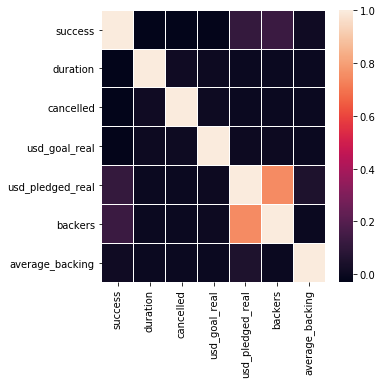

In [52]:
#correlation between the time, and goal and pldeged money
corr_time = df_encoded[['success','duration', 'cancelled', 'usd_goal_real', 
                        'usd_pledged_real', 'backers', 'average_backing']].corr()

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(corr_time, xticklabels=corr_time.columns, yticklabels=corr_time.columns, 
            ax=ax, linewidths=0.01);

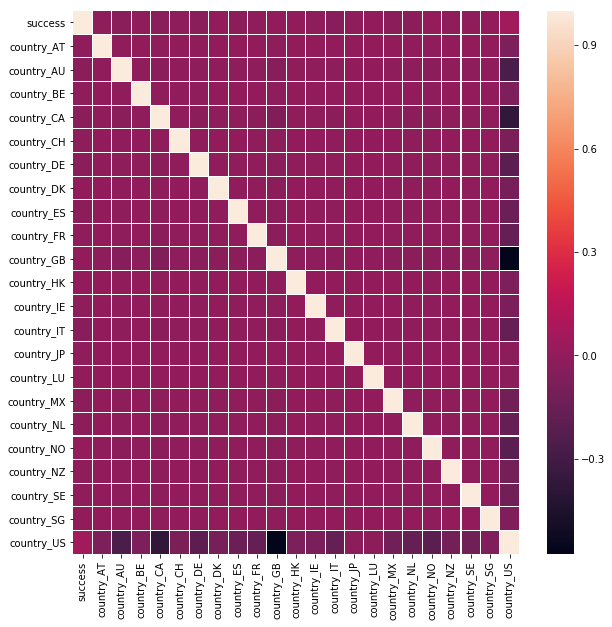

In [28]:
#correlation between success and country of origin for project
corr_country = df_encoded[['success', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT',
       'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO',
       'country_NZ', 'country_SE', 'country_SG', 'country_US']].corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_country, xticklabels=corr_country.columns, yticklabels=corr_country.columns, 
            ax=ax, linewidths=0.01);

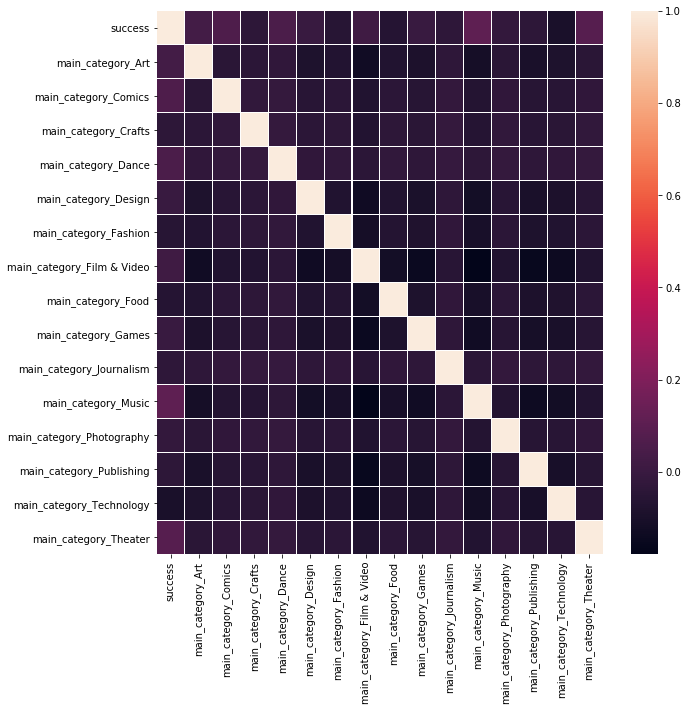

In [29]:
#correlation between sphere of project and success
corr_cat = df_encoded[['success','main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater']].corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_cat, xticklabels=corr_cat.columns, yticklabels=corr_cat.columns, ax=ax, 
            linewidths=0.01);

In [53]:
#number of dollars pledged per hour
(df_encoded.usd_pledged_real/(df_encoded.duration+1)).describe()

count    378661.000000
mean         11.976360
std         116.407377
min           0.000000
25%           0.040531
50%           0.842644
75%           5.575035
max       27010.605936
dtype: float64

#### ML Classification Model
Let's see if we can accurately predict which projects will be successful and which ones won't.
We will use a random forest classifier as this ensemble learner is usually quite powerful, and is not distance based (so we dont have to further scale the features like `duration` or `usd_pledged_real` or `usd_goal_real`)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(['success'], axis='columns').values,
                                                    df_encoded.success, 
                                                    test_size=0.2)

In [81]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)
forest_test_predictions = rand_forest.predict(X_test)
print(accuracy_score(y_test, forest_test_predictions))

0.9938732124701253


In [95]:
#importance of features rounded to nearest 3 decimals
rand_forest.feature_importances_.round(3)

array([0.285, 0.403, 0.251, 0.   , 0.027, 0.001, 0.001, 0.   , 0.   ,
       0.003, 0.001, 0.001, 0.001, 0.003, 0.   , 0.006, 0.   , 0.001,
       0.003, 0.002, 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.002, 0.   , 0.   , 0.   , 0.001])

This model does pretty well, however we have included the `usd_pledged_real` and `backers` features in this which might be skewing the results. Remember that `usd_pledged_real` and `backers` were very highly correlated with `success` (obviously).

Lets remove this variable and see how the model does.

In [107]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').values,
                                                            df_encoded.success, test_size=0.2, random_state=0)
rand_forest_2 = RandomForestClassifier(random_state=42)
rand_forest_2.fit(X_train_2, y_train_2)
forest_test_predictions_2 = rand_forest_2.predict(X_test_2)
print(accuracy_score(y_test_2, forest_test_predictions_2))

0.6466929872050493


In [103]:
#importance of features rounded to nearest 3 decimals
rand_forest_2.feature_importances_.round(3)

array([0.429, 0.002, 0.473, 0.002, 0.005, 0.003, 0.004, 0.002, 0.005,
       0.003, 0.004, 0.003, 0.002, 0.012, 0.002, 0.003, 0.01 , 0.008,
       0.001, 0.002, 0.001, 0.002, 0.001, 0.002, 0.001, 0.001, 0.001,
       0.003, 0.001, 0.001, 0.002, 0.   , 0.   , 0.001, 0.001, 0.002,
       0.001, 0.001, 0.001, 0.004])

In [127]:
print(df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').columns[0])
print(df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').columns[2])
print(df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').columns[13])

usd_goal_real
duration
main_category_Music


In [125]:
#grid search to optimize random forest classifier
parameters={'n_estimators':[5,10,15,20],
            'max_depth':[None,2,5,10,15],
            'min_samples_split':[2, 4, 8]}
clf = RandomForestClassifier(random_state=42)
scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train_2, y_train_2)
best_clf = grid_fit.best_estimator_

In [118]:
predictions = best_clf.predict(X_test_2)

In [124]:
print(accuracy_score(y_test_2, predictions))

0.681380639879577


In [126]:
best_clf.feature_importances_.round(3)

array([0.412, 0.007, 0.266, 0.002, 0.024, 0.012, 0.015, 0.006, 0.027,
       0.004, 0.017, 0.004, 0.006, 0.053, 0.005, 0.014, 0.04 , 0.039,
       0.   , 0.002, 0.001, 0.003, 0.001, 0.003, 0.001, 0.001, 0.001,
       0.004, 0.001, 0.001, 0.004, 0.   , 0.   , 0.002, 0.002, 0.004,
       0.001, 0.001, 0.   , 0.015])

In [128]:
print(df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').columns[0])
print(df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').columns[2])
print(df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').columns[4])
print(df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').columns[8])
print(df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').columns[13])
print(df_encoded.drop(['success', 'usd_pledged_real', 'backers'], axis='columns').columns[17])

usd_goal_real
duration
main_category_Comics
main_category_Fashion
main_category_Music
main_category_Theater


### Conclusion

Based on the optimized Random Forest Classifier, for which we removed the `usd_pledged_real` and `backers` features as these were going to distort our model as we want to know what can help us get more backers and funding.

Based on the feature importance of the Random Forest Ensemble Learner, the most important features are `usd_goal_real`, `duration`, `main_category_Comics`, `main_category_Fashion`, `main_category_Music`, and `main_category_Theater`. This shows us that what we set as the monetary goal and how long we allow people to pledge for really does matter a lot. What is quite surprising for me, and is corroborated by the analysis of descriptive statistics is that Arts and Performance are more likely to succeed. I wonder why...

Overall I would not say there is one contributing factor to success on Kickstarter. Many things contribute to it that cannot be explained through data. For example, the business idea, planning, incentives to pledge, or project design cannot be easily quantified. Maybe if we had sentiment data from the comments on each project we could combine that into a much larger and better classification model to predict our success.